
Loading JSON: /content/strava_activities_filtered.json

Fields detected (after ignoring date/id/polyline): 18

     DATA ANALYSIS REPORT

NUMERIC FIELDS:
------------------------------------

• activity.comment_count
  count = 965
  unique = 2
  min   = 0
  max   = 1
  mean  = 0.0010


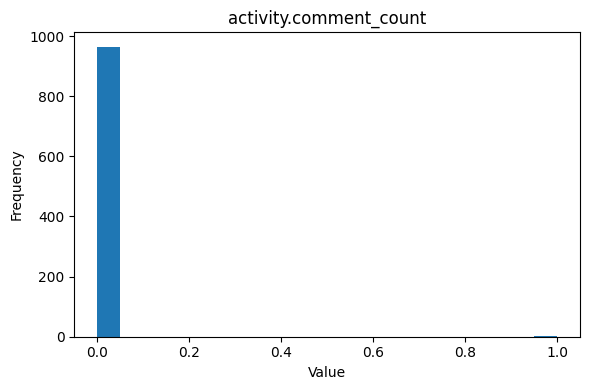


• activity.kudos_count
  count = 965
  unique = 6
  min   = 0
  max   = 6
  mean  = 0.0746


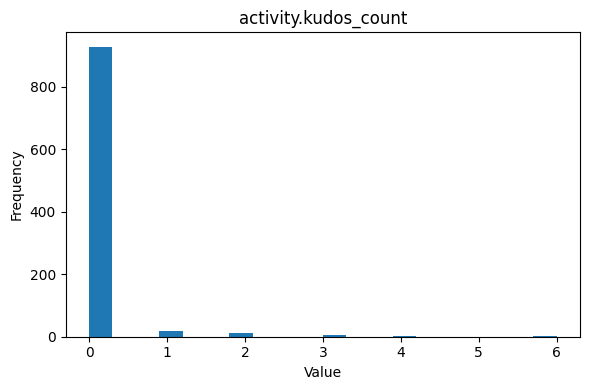


• activity.calories
  count = 965
  unique = 690
  min   = 0
  max   = 12567
  mean  = 686.5281


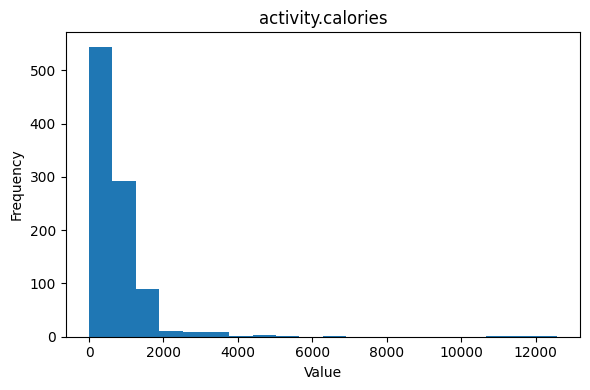


• activity.distance
  count = 965
  unique = 667
  min   = 0
  max   = 158947
  mean  = 8416.3963


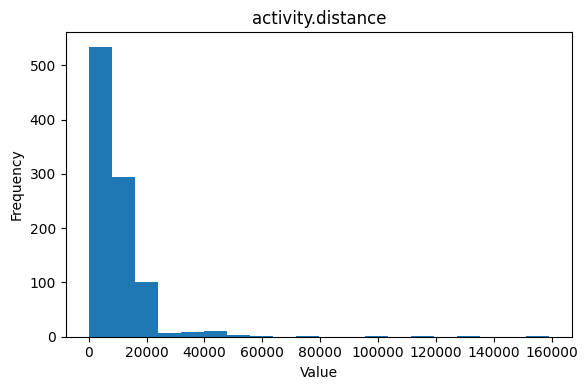


• activity.total_elevation_gain
  count = 965
  unique = 391
  min   = 0
  max   = 5521.7
  mean  = 48.3376


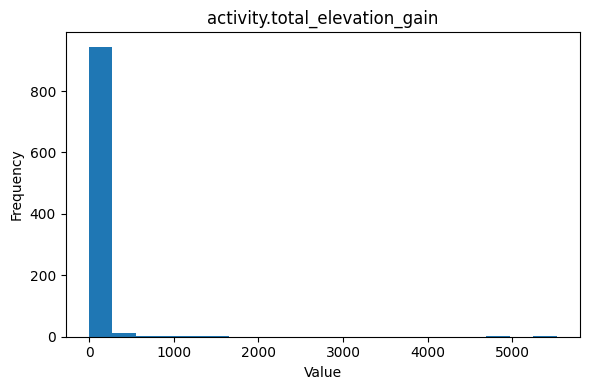


• activity.average_speed
  count = 965
  unique = 513
  min   = 0
  max   = 110.38
  mean  = 1.9898


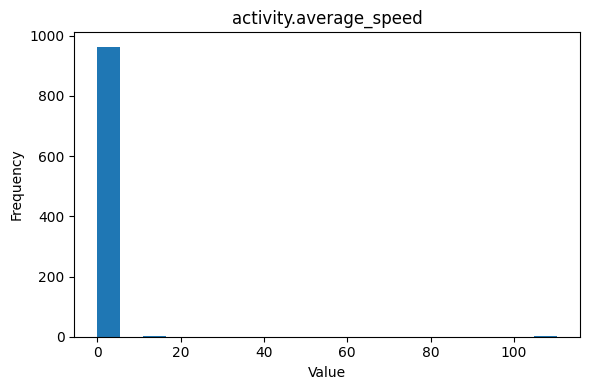


• activity.max_speed
  count = 965
  unique = 485
  min   = 0
  max   = 110.84
  mean  = 6.1915


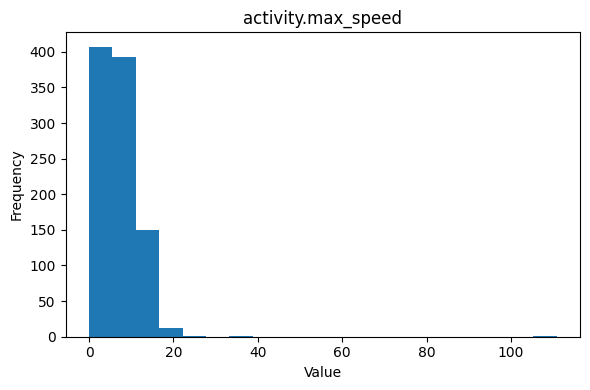


• activity.elapsed_time
  count = 965
  unique = 864
  min   = 1
  max   = 1644333
  mean  = 6684.9917


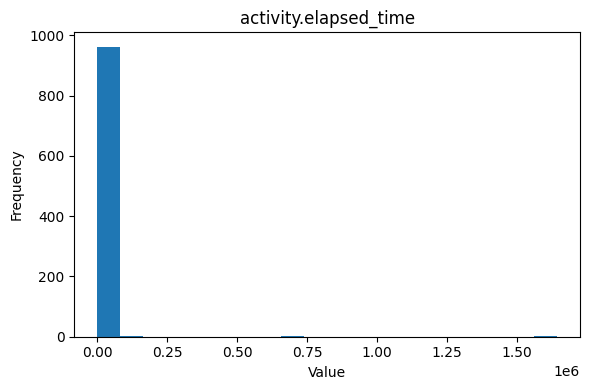


• activity.max_heartrate
  count = 670
  unique = 91
  min   = 68
  max   = 189
  mean  = 142.4851


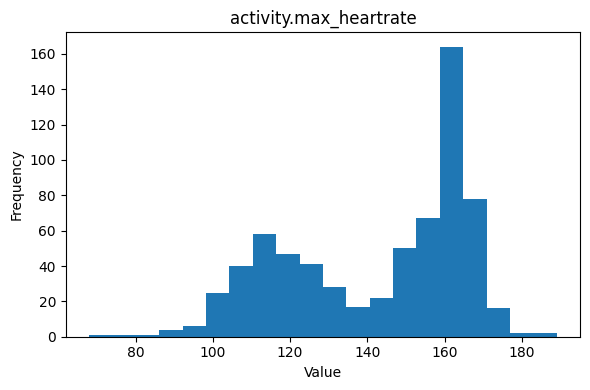


• activity.average_heartrate
  count = 670
  unique = 407
  min   = 0
  max   = 160
  mean  = 117.8276


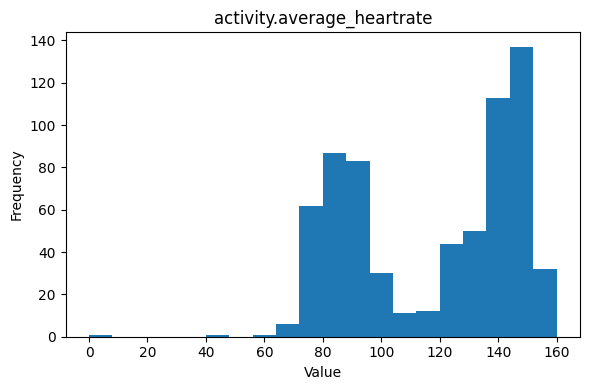


• activity.average_cadence
  count = 358
  unique = 113
  min   = 39.6
  max   = 82.8
  mean  = 73.6637


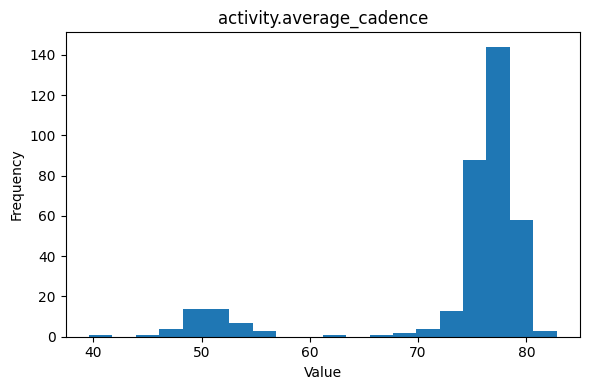


• activity.gear.converted_distance
  count = 567
  unique = 385
  min   = 8.9
  max   = 4248.2
  mean  = 780.6709


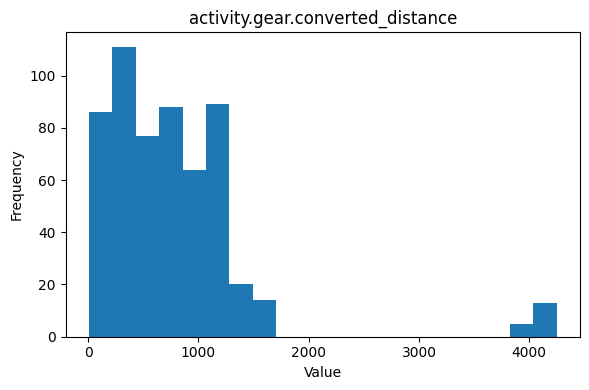


• activity.suffer_score
  count = 413
  unique = 118
  min   = 0
  max   = 371
  mean  = 33.3172


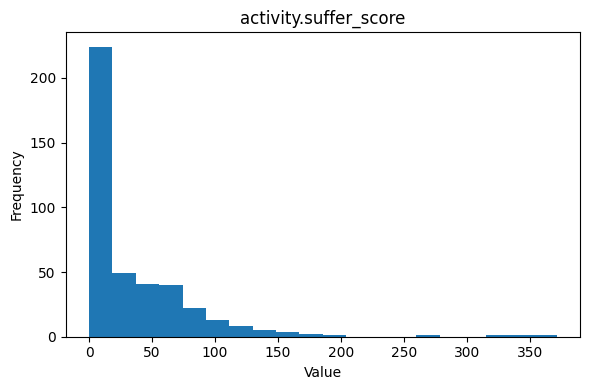


CATEGORICAL FIELDS:
------------------------------------

• activity.name
  unique categories = 88
   Afternoon Walk: 14
   Morning Run: 370
   Stretching: 256
   Morning Weight Training: 5
   Night Run: 103
   Afternoon Run: 34
   Badwater 267 VR - Day 14: 1
   Morning Stair-Stepper: 2
   Long walk with Aleksey: 1
   Morning Walk: 19
   Evening Run: 7
   Morning Ride: 9
   Afternoon Swim: 13
   Danang Marathon 2023: 1
   Hanoi. Day 1: 2
   Lunch Swim: 10
   Warming up for Danang Marathon: 1
   Morning Swim: 8
   Afternoon Weight Training: 3
   Lunch Walk: 4
   Full circle around West Lake: 1
   Lunch Run: 5
   Evening Swim: 7
   Evening Run with Aleksey: 1
   With Aleksey: 5
   Singapore 200 Miles Ultra - DNF: 1
   Badwater 267 VR - Day 5: 1
   Penang Hill Hike with Parents: 1
   Badwater 267 VR - Day 11: 2
   Badwater 267 VR - Day 2: 1
   Badwater 267 VR - Day 1: 2
   Cát Bà Run - Day 2: 1
   Exploring SG200 miles route: 1
   Badwater 267 VR - Day 4: 1
   Running in Penang: 1
   Bad

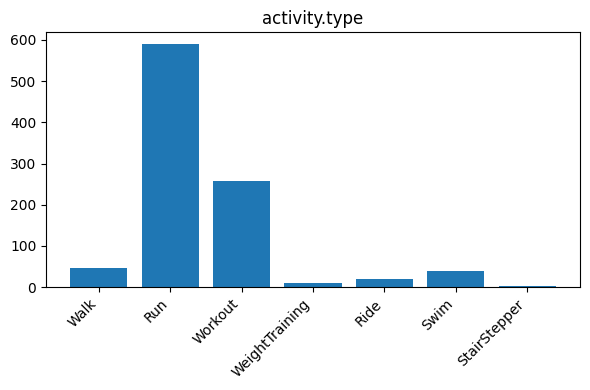


• activity.gear.name
  unique categories = 7
   ASICS Metaspeed Sky+: 65
   ASICS Hyper Speed 2: 75
   ASICS Hyper Speed 3: 123
   HOKA Mach 6: 162
   HOKA Rincon 3 Wide: 114
   Trek Verve: 18
   ASICS TARTHEREDGE 3: 10


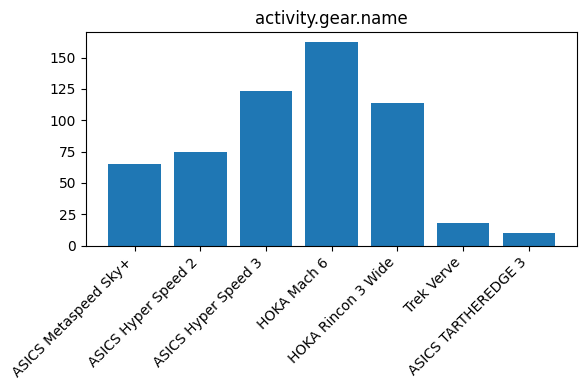


• activity.description
  unique categories = 56
   : 156
   Good run. New PR: 1
   Night runs are now a habit: 1
   Great views from top of the mountain. Very windy.: 1
   First time to complete West Lake route. Great place. I am coming back here: 1
   Running with my son. Passing the love of running to the next generation :) Probably the most meaningful 4k I ran.: 1
   Good try. Could not run and did not want to walk anymore. Will finish next time!: 1
   Exploring Ninh Bình center: 1
   Running barefoot on the sand beach was the best part: 1
   Hanna is about to be born in a few hours. I finished stretching and we rushed to hospital right after that: 1
   Back to the running track :D: 1
   Happy I have listened to my alarm clock :D: 1
   Back from school: 1
   Discovering new places and remembering the ones I've been to before: 1
   I am appreciating Singapore's PCNs and trails a lot more now :D : 1
   New PR. Quite happy with the time: 1
   First day in Nha Trang. What a good change

In [12]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import statistics
from typing import Any


# ----------------------------------------------------
# Helper: Should we ignore this field name?
# ----------------------------------------------------
def should_ignore_field(field_name: str) -> bool:
    name = field_name.lower()
    return (
        "date" in name
        or "id" in name
        or "polyline" in name
    )


# ----------------------------------------------------
# Recursive walker — collects all values by field path
# ----------------------------------------------------
def walk(prefix: str, obj: Any, store):
    """Recursively walk objects and store all values under their field path."""

    # Ignore field if its prefix contains disallowed keywords
    if should_ignore_field(prefix):
        return

    if isinstance(obj, dict):
        for k, v in obj.items():
            full = f"{prefix}.{k}" if prefix else k
            if should_ignore_field(full):
                continue
            walk(full, v, store)

    elif isinstance(obj, list):
        store[prefix].append(len(obj))
        for item in obj:
            walk(prefix, item, store)

    else:
        store[prefix].append(obj)


# ----------------------------------------------------
# Main analysis and plotting function
# ----------------------------------------------------
def analyze_activity(json_path):
    print(f"\nLoading JSON: {json_path}\n")

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    activities = [item["activity"] for item in data]

    collected = defaultdict(list)

    # collect all values
    for act in activities:
        walk("activity", act, collected)

    print("Fields detected (after ignoring date/id/polyline):", len(collected))
    print("\n====================================")
    print("     DATA ANALYSIS REPORT")
    print("====================================\n")

    numeric_fields = {}
    categorical_fields = {}
    boolean_fields = {}
    null_only_fields = []
    mixed_fields = {}

    for field, values in collected.items():

        # ignore all nulls
        non_null = [v for v in values if v is not None]
        if len(non_null) == 0:
            null_only_fields.append(field)
            continue

        # remove constant fields and fully unique fields
        unique_count = len(set(non_null))
        total_count = len(non_null)

        if unique_count == 1 or unique_count == total_count:
            continue

        types = set(type(v) for v in non_null)

        if types <= {int, float}:
            numeric_fields[field] = non_null

        elif types == {str}:
            categorical_fields[field] = non_null

        elif types == {bool}:
            boolean_fields[field] = non_null

        else:
            mixed_fields[field] = types

    # ----------------------------------------
    # Numeric distributions
    # ----------------------------------------
    print("NUMERIC FIELDS:")
    print("------------------------------------")

    for field, values in numeric_fields.items():
        print(f"\n• {field}")
        print(f"  count = {len(values)}")
        print(f"  unique = {len(set(values))}")
        print(f"  min   = {min(values)}")
        print(f"  max   = {max(values)}")
        print(f"  mean  = {statistics.mean(values):.4f}")

        plt.figure(figsize=(6, 4))
        plt.hist(values, bins=20)
        plt.title(f"{field}")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    # ----------------------------------------
    # Categorical distributions
    # ----------------------------------------
    print("\nCATEGORICAL FIELDS:")
    print("------------------------------------")

    for field, values in categorical_fields.items():
        counts = Counter(values)

        print(f"\n• {field}")
        print(f"  unique categories = {len(counts)}")

        for k, c in counts.items():
            print(f"   {k}: {c}")

        if len(counts) <= 30:
            plt.figure(figsize=(6, 4))
            plt.bar(list(counts.keys()), list(counts.values()))
            plt.xticks(rotation=45, ha='right')
            plt.title(f"{field}")
            plt.tight_layout()
            plt.show()

    # ----------------------------------------
    # Boolean distributions
    # ----------------------------------------
    print("\nBOOLEAN FIELDS:")
    print("------------------------------------")

    for field, values in boolean_fields.items():
        counts = Counter(values)

        # ignore if only True or only False
        if len(counts) == 1:
            continue

        print(f"\n• {field}")
        print(f"   True:  {counts.get(True, 0)}")
        print(f"   False: {counts.get(False, 0)}")

        plt.figure(figsize=(4, 4))
        plt.bar(["False", "True"], [counts.get(False, 0), counts.get(True, 0)])
        plt.title(f"Boolean Distribution:\n{field}")
        plt.tight_layout()
        plt.show()

    print("\n\n=== ANALYSIS COMPLETE ===\n")


# ----------------------------------------------------
# Run with your path
# ----------------------------------------------------
analyze_activity("/content/strava_activities_filtered.json")



Loading: /content/strava_activities_filtered.json
Fields kept for numeric analysis: 13
['activity.comment_count', 'activity.kudos_count', 'activity.calories', 'activity.distance', 'activity.total_elevation_gain', 'activity.average_speed', 'activity.max_speed', 'activity.elapsed_time', 'activity.max_heartrate', 'activity.average_heartrate', 'activity.average_cadence', 'activity.gear.converted_distance', 'activity.suffer_score']


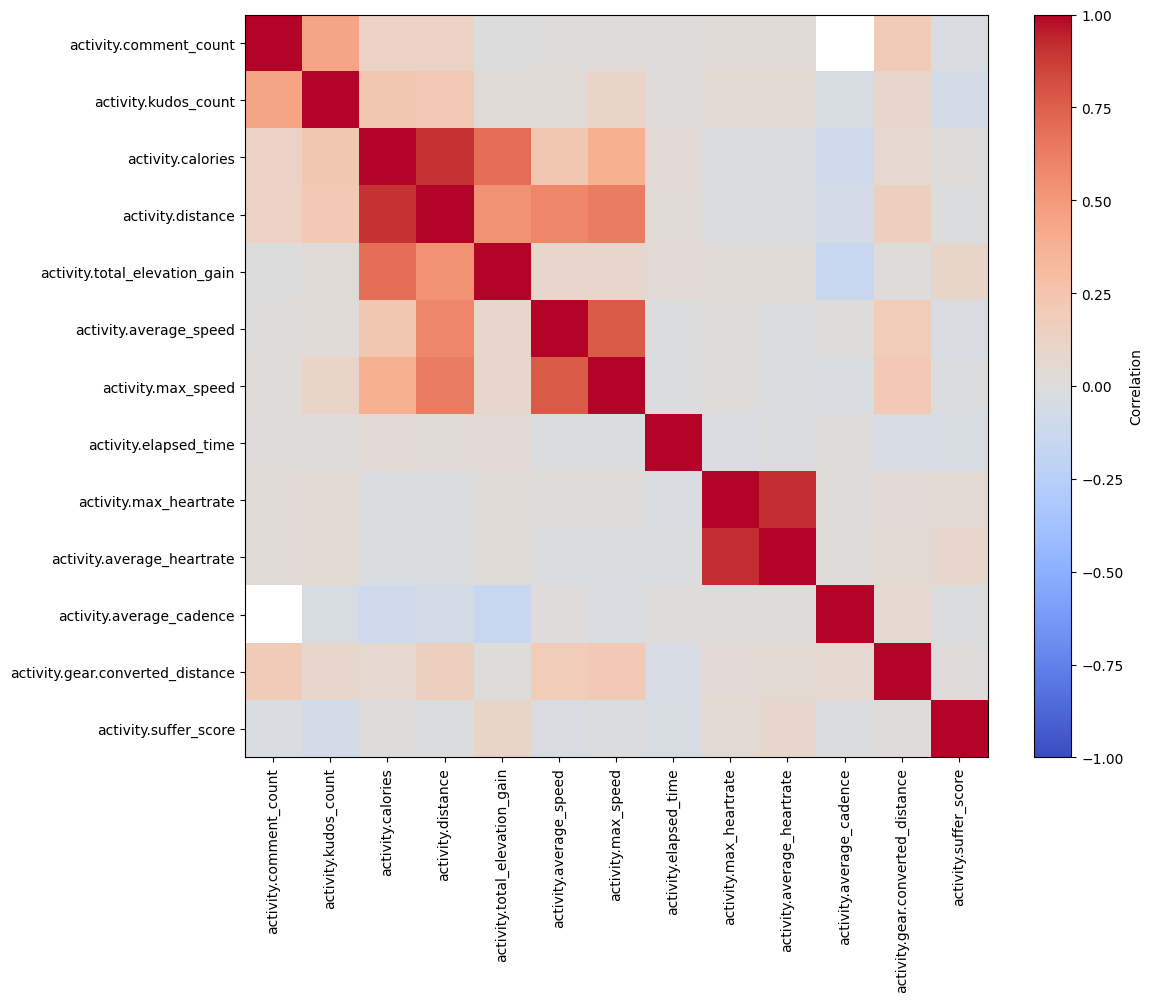


Strong correlations (|r| >= 0.6):
  activity.calories  vs  activity.distance : r = 0.905


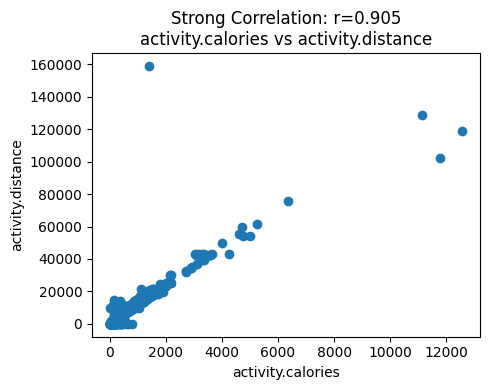

  activity.calories  vs  activity.total_elevation_gain : r = 0.695


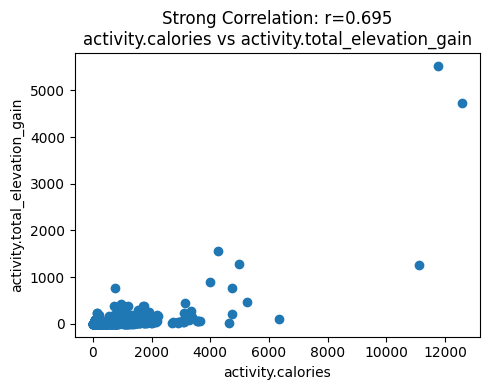

  activity.distance  vs  activity.max_speed : r = 0.630


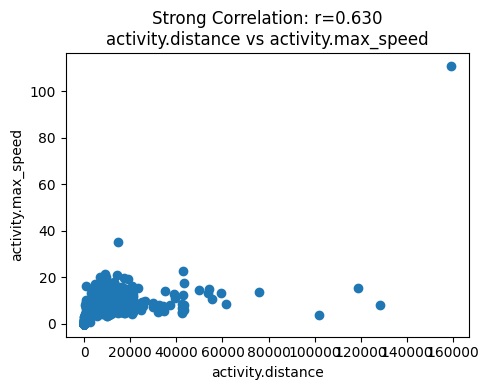

  activity.average_speed  vs  activity.max_speed : r = 0.771


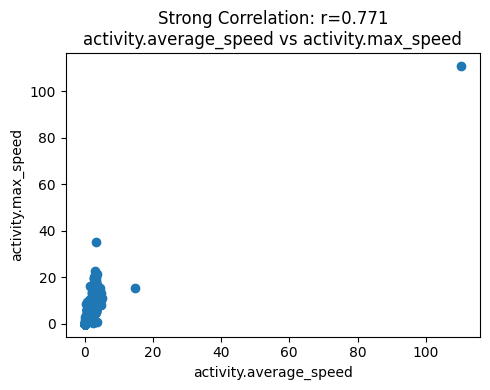

  activity.max_heartrate  vs  activity.average_heartrate : r = 0.918


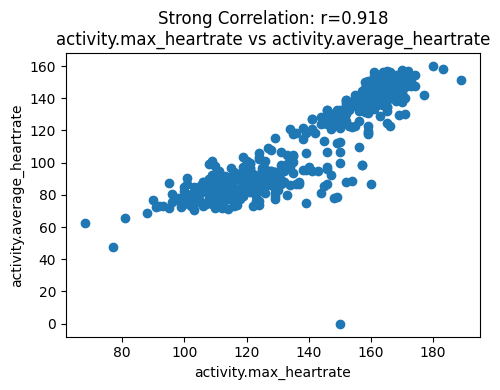

In [16]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from typing import Any

# ----------------------------------------------------
# Ignore fields containing these substrings
# ----------------------------------------------------
def should_ignore_field(field_name: str) -> bool:
    name = field_name.lower()
    return "date" in name or "id" in name or "polyline" in name

# ----------------------------------------------------
# Recursively gather numeric values by field path
# ----------------------------------------------------
def walk(prefix: str, obj: Any, store):
    if should_ignore_field(prefix):
        return

    if isinstance(obj, dict):
        for k, v in obj.items():
            full = f"{prefix}.{k}" if prefix else k
            if should_ignore_field(full):
                continue
            walk(full, v, store)

    elif isinstance(obj, list):
        # Treat list length as a numeric signal
        store[prefix].append(len(obj))
        for item in obj:
            walk(prefix, item, store)

    else:
        # Handle numeric only; keep bool separate later
        if isinstance(obj, (int, float)) and not isinstance(obj, bool):
            store[prefix].append(obj)

# ----------------------------------------------------
# Build dataframe from collected numeric fields
# ----------------------------------------------------
def make_dataframe(collected):
    filtered = {}
    for field, values in collected.items():
        non_null = [v for v in values if v is not None]

        if len(non_null) < 5:
            continue

        unique = len(set(non_null))

        # Remove constant & all-unique
        if unique <= 1 or unique == len(non_null):
            continue

        filtered[field] = non_null

    if not filtered:
        return pd.DataFrame()

    # To handle unequal lengths, pad with nan
    max_len = max(len(v) for v in filtered.values())
    df = pd.DataFrame({
        k: v + [np.nan] * (max_len - len(v))
        for k, v in filtered.items()
    })

    return df

# ----------------------------------------------------
# CORRELATION + SURPRISINGNESS ANALYSIS
# ----------------------------------------------------
def analyze_correlations(json_path):
    print(f"\nLoading: {json_path}")

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    activities = [item["activity"] for item in data]

    collected = defaultdict(list)
    for act in activities:
        walk("activity", act, collected)

    # Build usable dataframe
    df = make_dataframe(collected)
    if df.empty:
        print("No numeric data to analyze.")
        return

    print(f"Fields kept for numeric analysis: {len(df.columns)}")
    print(list(df.columns))

    # ----------------------------------------------------
    # 1. Correlation Heatmap
    # ----------------------------------------------------
    corr = df.corr(numeric_only=True)

    plt.figure(figsize=(12, 10))
    plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(label="Correlation")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------
    # 2. Strong Correlation Scatter Plots
    # ----------------------------------------------------
    threshold = 0.6
    strong_pairs = [
        (c1, c2, corr.iloc[i, j])
        for i, c1 in enumerate(corr.columns)
        for j, c2 in enumerate(corr.columns)
        if j > i and abs(corr.iloc[i, j]) >= threshold
    ]

    print("\nStrong correlations (|r| >= 0.6):")
    for a, b, r in strong_pairs:
        print(f"  {a}  vs  {b} : r = {r:.3f}")
        plt.figure(figsize=(5, 4))
        plt.scatter(df[a], df[b])
        plt.xlabel(a)
        plt.ylabel(b)
        plt.title(f"Strong Correlation: r={r:.3f}\n{a} vs {b}")
        plt.tight_layout()
        plt.show()

# ----------------------------------------------------
# RUN
# ----------------------------------------------------
analyze_correlations("/content/strava_activities_filtered.json")
